In [1]:
# imports

import csv
import json
import os
import re
from pprint import pprint

import gensim
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import PyPDF2
import spacy
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

# set seed for reproducibility
# np.random.seed(493)


nltk.download("stopwords")
nltk.download("wordnet")
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

ps = nltk.porter.PorterStemmer()

import re
import unicodedata

import openai
from gsdmm import MovieGroupProcess

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
stop_words = stopwords.words("english")

import time

from nltk.sentiment.vader import SentimentIntensityAnalyzer

/opt/conda/lib/python3.10/site-packages/PyPDF2/__init__.py:21: DeprecationWarning: PyPDF2 is deprecated. Please move to the pypdf library instead.
  warnings.warn(
2023-02-25 03:55:20.870011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 03:55:21.679196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-25 03:55:21.679330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

## Functions for Text Cleaning and Topic Modeling (Same as before)

In [2]:
def tokeniz(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))


# function to filter out stopwords
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


# function for lemmatization
def lemmatize(texts, allowed_postags=["NOUN", "ADJ", "VERB"]):
    texts_op = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_op.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_op


from copy import deepcopy


def top_words(cluster_word_distribution, top_cluster, values):
    words = []
    for cluster in top_cluster:
        sort_dicts = sorted(
            cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True
        )[:values]
        words.append([w[0] for w in sort_dicts])
        # print('Cluster %s : %s'%(cluster,sort_dicts))
        # print('-'*120)
    words1 = deepcopy(words)
    for i in range(len(words)):
        for j in range(len(words[i])):
            for k in range(len(words)):
                if k != i and words[i][j] in words[k]:
                    try:
                        words1[i].remove(words[i][j])
                        words1[k].remove(words[i][j])
                    except:
                        pass
    return words1


def create_topics_dataframe(data_text, mgp, threshold, topic_dict, stem_text):
    result = pd.DataFrame(columns=["text", "topic", "stems"])
    for i, text in enumerate(data_text):
        result.at[i, "text"] = text
        result.at[i, "stems"] = stem_text[i]
        prob = mgp.choose_best_label(stem_text[i])
        if prob[1] >= threshold:
            result.at[i, "topic"] = topic_dict[prob[0]]
        else:
            result.at[i, "topic"] = "Other"
    return result

In [3]:
import os
import sys
from contextlib import contextmanager


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [4]:
# Building Bigram & Trigram Models
# bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)


# function to filter out stopwords
def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


# function to create bigrams
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


# function to create trigrams
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]


# function for lemmatization
def lemmatize(texts, allowed_postags=["NOUN", "ADJ", "VERB"]):
    texts_op = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_op.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        )
    return texts_op

In [5]:
nltk.download([
...     "names",
...     "stopwords",
...     "state_union",
...     "twitter_samples",
...     "movie_reviews",
...     "averaged_perceptron_tagger",
...     "vader_lexicon",
...     "punkt",
... ])

[nltk_data] Downloading package names to /home/jovyan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Packag

True

## Organizing Transcript-Topics (Same as Before)
Final data saves with transcript, topic keywords, sentiment, and program

In [299]:
tr_tp_st = [[], [], [], []]

gl = pd.read_csv("foxGuestList.csv", encoding="windows-1252")
fox = open("fox_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])


gl = pd.read_csv("msnbcGuestList.csv", encoding="windows-1252")
fox = open("msnbc_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            if len(df) > 2:
                tr_tp_st[0].append(l + 5000)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])

gl = pd.read_csv("CNNGuestList.csv", encoding="windows-1252")
fox = open("cnn_text.txt", "r", encoding="windows-1252")
fox = fox.readlines()
for l in range(len(fox)):
    #######################################
    ##Turning transcript into df of lines##
    #######################################
    lines = pd.DataFrame(
        columns=["Date", "Start_Hour", "Program", "Title", "Speaker", "Line"]
    )
    # print(lines)
    transcript = fox[l]
    meta = gl.iloc[l, :]
    dt = meta["Date"]
    if "January" in str(dt):
        print(l)
        chunks = transcript.split("|")
        line = ""
        spkr = ""
        for c in chunks:
            if (
                "Page" not in c[0:10]
                and "...." not in c
                and c[0:15] not in meta["Title"]
            ):
                # print(c)
                if ":" in c:
                    c = c.split(":")
                    if str.isupper(c[0]):
                        lines.loc[len(lines)] = [
                            meta["Date"],
                            meta["Start_Hour"],
                            meta["Program"],
                            meta["Title"],
                            spkr,
                            line,
                        ]
                        # print(spkr + ':' + line)
                        spkr = c[0]
                        line = c[1]
                else:
                    line += c
        lines.loc[len(lines)] = [
            meta["Date"],
            meta["Start_Hour"],
            meta["Program"],
            meta["Title"],
            spkr,
            line,
        ]

        # cleaning Speaker
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.strip())
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x.split(","))
        lines["Speaker"] = lines["Speaker"].apply(lambda x: x[0])
        speakers = []
        spkr_list = lines["Speaker"].unique()
        for s in lines["Speaker"]:
            s1 = s.split(" ")
            if len(s1) == 1:
                for s2 in spkr_list:
                    if s1[0] in s2:
                        speakers.append(s2)
                        break
            else:
                speakers.append(s)
        lines["Speaker"] = speakers
        # lines.to_csv('fox_lines_test.csv')
        data = lines["Line"]

        # cleaning text
        processed_data = list(tokeniz(data))

        ####################################
        ##cleaning text for topic modeling##
        ####################################
        # Building Bigram & Trigram Models
        bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)
        bigram_mod = gensim.models.phrases.Phraser(bigram)

        # function to filter out stopwords
        def remove_stopwords(texts):
            return [
                [word for word in simple_preprocess(str(doc)) if word not in stop_words]
                for doc in texts
            ]

        # function to create bigrams
        def create_bigrams(texts):
            return [bigram_mod[doc] for doc in texts]

        # removing stopwords, creating bigrams and lemmatizing the text
        data_wo_stopwords = remove_stopwords(processed_data)
        data_bigrams = create_bigrams(data_wo_stopwords)
        data_lemmatized = lemmatize(
            data_bigrams, allowed_postags=["NOUN", "ADJ", "VERB"]
        )

        ######################
        #####TOPIC MODELING###
        ######################

        texts = data_lemmatized
        mgp = MovieGroupProcess(K=5, alpha=0.1, beta=0.1, n_iters=30)

        vocab = set(x for doc in texts for x in doc)
        n_terms = len(vocab)
        with suppress_stdout():
            y = mgp.fit(texts, n_terms)
        doc_count = np.array(mgp.cluster_doc_count)
        top_index = doc_count.argsort()[-10:][::-1]
        tw = top_words(mgp.cluster_word_distribution, top_index, 15)

        topic_dict = {}

        for i, topic_num in enumerate(top_index):
            topic_dict[topic_num] = i

        dfx = create_topics_dataframe(
            data_text=lines["Line"],
            mgp=mgp,
            threshold=0.3,
            topic_dict=topic_dict,
            stem_text=texts,
        )

        transcript = pd.merge(lines, dfx, left_on="Line", right_on="text")

        ######################
        ##Sentiment Analysis##
        ######################
        transcript["stems_str"] = transcript["stems"].apply(lambda x: " ".join(x))
        sid = SentimentIntensityAnalyzer()
        transcript["VADER"] = transcript["Line"].apply(
            lambda x: list(sid.polarity_scores(x).values())[3]
        )

        ######################
        ##Storing Each Topic##
        ######################
        for t in range(len(transcript["topic"].unique())):
            df = transcript[transcript["topic"] == t]

            #if statement used to remove topics with only one or two statements
            if len(df) > 2:
                tr_tp_st[0].append(l + 10000)
                tr_tp_st[1].append(tw[t])
                tr_tp_st[2].append(df["VADER"].mean())
                tr_tp_st[3].append(lines["Program"][0])


21
36
38
48
53
85
86
90
91
105
115
141
146
168
243
251
270
284
332
338
344
401
407
441
442
459
461
470
473
475
490
491
496
497
501
505
508
511
513
514
520
537
546
584
600
601
646
648
656
699
706
740
741
742
750
790
811
832
833
856
857
859
860
861
862
863
864
869
870
871
873
887
891
892
893
894
895
921
923
986
1058
1083
1090
1098
1099
1102
1107
1116
1123
1174
1223
1227
1228
1254
1279
1286
1294
1295
1300
1308
1309
1310
1311
1312
1313
1314
1319
1401
1409
1426
1445
1482
1525
1530
1531
1536
1564
1565
1597
1599
1611
1612
1617
1628
1638
1644
1703
1715
1716
1717
1798
1859
1871
1881
1883
1897
1906
1919
1959
1982
1983
1996
2001
2009
2017
2025
2043
2044
2055
2059
2071
2074
2079
2096
2097
2103
2128
2148
2159
2160
2171
2184
2185
2186
2189
2194
2195
2230
2238
2244
2245
2248
2263
2269
2271
2273
2283
2293
2302
2303
2306
2307
2312
2325
2326
2327
2328
2362
2374
2400
2406
2434
2451
2457
2469
2470
2473
2474
2485
2495
2503
2504
2507
2508
2509
2510
2511
2512
2513
2539
2572
2582
2584
2586
2607
2616
2628
2633

IndexError: single positional indexer is out-of-bounds

In [300]:
print(tr_tp_st[0][:5])
print(tr_tp_st[1][:5])
print(tr_tp_st[2][:5])
print(tr_tp_st[3][:5])
print(len(tr_tp_st[1]))
print(tr_tp_st[3][1440])

[21, 21, 21, 21, 21]
[['generation', 'word', 'free', 'people', 'vote', 'impeachment', 'election'], ['take', 'stage', 'mueller', 'evidence', 'grief', 'history', 'happen'], ['information', 'memo', 'medium', 'comey', 'leak', 'course'], ['month', 'country', 'family', 'give', 'bring', 'remember', 'look', 'question', 'name'], ['tonight', 'liberal', 'angle', 'kid']]
[0.11589454545454544, -0.08265757575757575, -0.138925, -0.020872222222222205, -0.06732857142857143]
['Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE', 'Fox News Network INGRAHAM ANGLE']
6594
MSNBC 11TH HOUR WITH BRIAN WILLIAMS


## Calculating Similarities Between Topics - Cosine similarity

In [303]:
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
topics = [' '.join(map(str, l)) for l in tr_tp_st[1]]
topics = np.array(topics, dtype=str)
vectorizer = CountVectorizer().fit_transform(topics)
vectors = vectorizer.toarray()
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [304]:
csim = cosine_similarity(vectors)


In [305]:
#counting the number of nonzero results
d = 0
for i in csim[0]:
    if i > 0:
        d+=1 
print(d)

1476


## getting differences

In [306]:
#I think I accidently deleted the import for combinations and squareform (oops)
diff = [2 - abs(i - j) for (i, j) in combinations(tr_tp_st[2], 2)]
m = np.mean(diff)
std = np.std(diff)
#print(std)
#print(m)
#diff = [(2 - abs(i - j) - m) / std for (i, j) in combinations(tr_tp_st[2], 2)]
diff_matrix = squareform(diff)
print(len(diff_matrix))

6594


In [307]:
sim_sent = np.multiply(csim, diff_matrix)
print(csim[0][500:550])
print(diff_matrix[0][500:550])
sim_sent[0][500:550]

[0.         0.         0.         0.         0.         0.
 0.         0.12598816 0.         0.         0.12598816 0.
 0.         0.         0.13363062 0.16903085 0.         0.16903085
 0.13363062 0.         0.         0.10910895 0.11396058 0.
 0.         0.         0.         0.16903085 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.11396058
 0.         0.         0.         0.         0.13363062 0.
 0.         0.        ]
[1.94080816 1.76909355 1.88911033 1.50021879 1.83555091 1.8121308
 1.69673212 1.74940129 1.94059931 1.81532124 1.93204397 1.76005288
 1.93810152 1.78050121 1.40166545 1.91855169 1.83610372 1.99201879
 1.97413045 1.87756795 1.94196664 1.85641455 1.99175631 1.99336955
 1.82070121 1.81891598 1.90081598 1.86912831 1.83723879 1.81934663
 1.73849858 1.88414644 1.85117688 1.91242698 1.82573045 1.83716982
 1.9026749  1.97446351 1.83717502 1.83340545 1.95135688 1.87896528
 1.9521185  1.831235

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.22040385, 0.        , 0.        ,
       0.24341466, 0.        , 0.        , 0.        , 0.18730543,
       0.32429442, 0.        , 0.33671263, 0.26380428, 0.        ,
       0.        , 0.20255143, 0.2269817 , 0.        , 0.        ,
       0.        , 0.        , 0.31594035, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.21412797, 0.        , 0.        , 0.        ,
       0.        , 0.25557051, 0.        , 0.        , 0.        ])

## Aggregating

In [310]:
# turning transcript-topics into a dataframe and adding an id var
tdf = pd.DataFrame(
    zip(tr_tp_st[0], tr_tp_st[1], tr_tp_st[2], tr_tp_st[3]),
    columns=["Transcript", "Topic", "Sentiment", "Program"],
)
id = []
for i in range(len(tr_tp_st[0])):
    try:
        id.append(str(tr_tp_st[0][i]) + tr_tp_st[1][i][0])
    except:
        print("oops " + str(tr_tp_st[0][i]))
        id.append(str(tr_tp_st[0][i]))
tdf["id"] = id

### By transcript (Not primarily used)

In [311]:
prog_list = tdf['Transcript'].unique()
tprogs = tdf['Transcript']
P = []
for i in range(len(prog_list)):
    p = prog_list[i]
    r = [1 if p == t else 0 for t in tprogs]
    P.append(r)
P = np.array(P, dtype='float64')
print(P.shape)
print(P[0])


#colors just a list of program channels for use in graphs
colors = []
t = 0
print(len(tdf['Transcript'].unique()))
for i in range(len(tdf['Program'])):
    p = tdf['Program'][i]
    j = tdf['Transcript'][i]
    if j != t:
        t = j
        if 'CNN' in p:
            colors.append(0)
        elif 'MSNBC' in p:
            colors.append(-1)
        elif 'Fox' in p:
            colors.append(1)
        else:
            print('ah')
print(len(colors))
P[0][1120:1130]

(1391, 6594)
[1. 1. 1. ... 0. 0. 0.]
1391
1391


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### By Program (What I ended up using)

In [324]:
prog_list = tdf['Program'].unique()
tprogs = tdf['Program']
P = []
for i in range(len(prog_list)):
    p = prog_list[i]
    r = [1 if p == t else 0 for t in tprogs]
    P.append(r)
P = np.array(P, dtype='float64')
print(P.shape)
print(P[0])

#colors just a list of program channels for use in graphs
colors = []
for p in prog_list:
    if 'CNN' in p:
        colors.append(0)
    elif 'MSNBC' in p:
        colors.append(-1)
    elif 'Fox' in p:
        colors.append(1)
    else:
        print('ah')


(51, 6594)
[1. 1. 1. ... 0. 0. 0.]


Making differences x program matrix (P * S * P^T, S = topic sentiment difference scores * topic simmilarity score)

In [325]:
M = np.matmul(np.matmul(P,sim_sent),P.T)
print(M.shape)
M[0][1120:1130]

(51, 51)


array([], dtype=float64)

Makind topic simmilarity x program matrix (P * S * P^T, S = simmilarity score between topics)

In [326]:
M1 = np.matmul(np.matmul(P,csim),P.T)
M1[0][0:50]
M1[0][1120:1130]

array([], dtype=float64)

Element-wise multiply M time M1 ^ -1 to get average sentiment difference => sum(weighted sent difference) / sum(topic similarity)

In [327]:
M2 = np.multiply(M, np.power(M1, -1))
M2.shape
np.argwhere(np.isnan(M2))
M2[np.isnan(M2)] = 0

In [321]:
print(len(np.argwhere(np.isnan(M2))))
M2.size

36972


1934881

## Plotting programs (M2) with a bunch of manifold learning methods
### Plot color is program channel
Plot code pulled from here: https://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html#sphx-glr-auto-examples-manifold-plot-manifold-sphere-py

standard: 0.011 sec
ltsa: 0.011 sec
hessian: 0.014 sec
modified: 0.012 sec
ISO: 0.013 sec
MDS: 0.011 sec
Spectral Embedding: 0.0062 sec


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


t-SNE: 0.6 sec


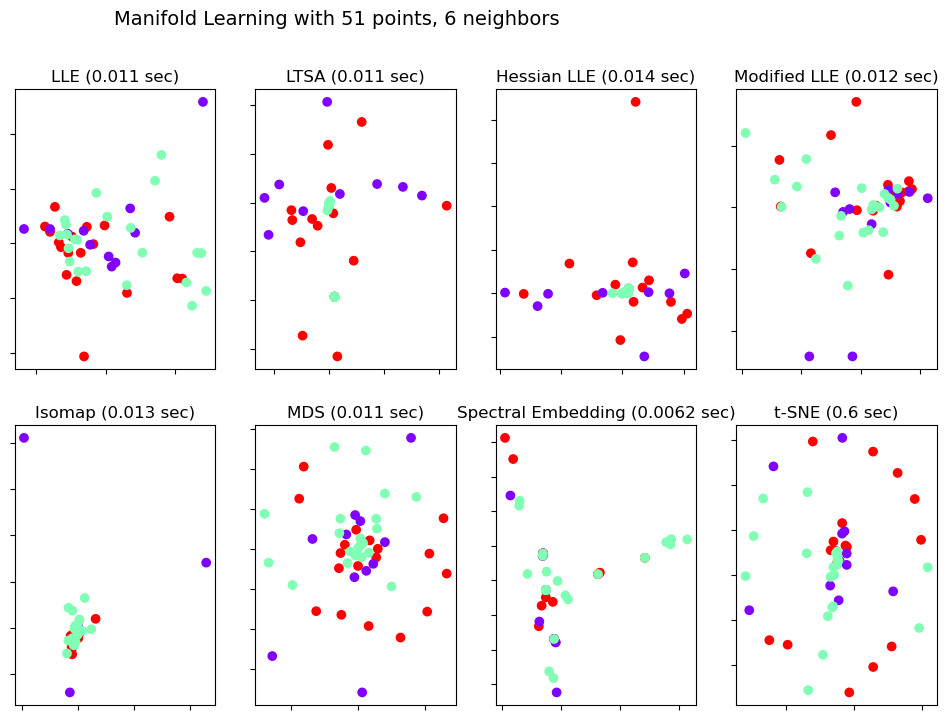

In [337]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

# Variables for manifold learning.
n_neighbors = 6
n_samples = 51

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (51, n_neighbors), fontsize=14
)

#colors = colors[:1340]

sphere_data = M2

# Perform Locally Linear Embedding Manifold learning
methods = ["standard", "ltsa", "hessian", "modified"]
labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]

for i, method in enumerate(methods):
    t0 = time()
    trans_data = (
        manifold.LocallyLinearEmbedding(
            n_neighbors=n_neighbors, n_components=2, method=method
        )
        .fit_transform(sphere_data)
        .T
    )
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")

# Perform Isomap Manifold learning.
t0 = time()
trans_data = (
    manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
    .fit_transform(sphere_data)
    .T
)
t1 = time()
print("%s: %.2g sec" % ("ISO", t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ("Isomap", t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1, normalized_stress="auto")
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=n_neighbors)
trans_data = se.fit_transform(sphere_data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

plt.show()